# US Name
 Replicate figure 1 Share of HS6 processing export of 2006


# Description

- Action: Replicate figure 1 Share of HS6 processing export of 2006
- Action: Replicate figure 2 Average VAT rebate share
- Action: Replicate figure 3 Distribution of unique rebate share

## Variables
### Target

kandhelwal_quality

### Features

- lag_tax_rebate

## Complementary information



# Metadata

- Key: 209_VAT_rebate_quality
- Epic: Summary statisticts
- US: Figures and tables
- Task tag: #figures, #summary-statistics, #publish
- Analytics reports: 

# Input Cloud Storage

## Table/file

**Name**

- china_vat_quality

**Github**

- https://github.com/thomaspernet/VAT_rebate_quality_china/blob/master/01_data_preprocessing/02_transform_tables/04_baseline_vat_quantity_covariates.md



# Connexion server

In [ ]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil, json
import sys
import janitor

path = os.getcwd()
parent_path = str(Path(path).parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [ ]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [ ]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


filter data: Need to keep only same product-city-destination by regime

In [ ]:
query = """
SELECT 
  *
FROM 
  chinese_trade.china_vat_quality 
  LEFT JOIN (
    SELECT 
      * 
    FROM 
      (
        SELECT 
          year, 
          hs6, 
          geocode4_corr, 
          country_en, 
          COUNT(
            DISTINCT(regime)
          ) as cn,
          COUNT(*
          ) as cn_1
        FROM 
          chinese_trade.china_vat_quality 
        GROUP BY 
          year, 
          hs6, 
          geocode4_corr, 
          country_en
      )
  ) as cn on china_vat_quality.year = cn.year 
  and china_vat_quality.hs6 = cn.hs6
  and china_vat_quality.geocode4_corr = cn.geocode4_corr
  and china_vat_quality.country_en = cn.country_en
  WHERE cn = 2
"""
df_unique = s3.run_query(
            query=query,
            database="chinese_trade",
            s3_output='SQL_OUTPUT_ATHENA',
            filename='fig1',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = {'hs6':'string'}
)

In [ ]:
list_to_keep = list(df_unique['hs6'].astype(str).unique())

In [ ]:
len(list_to_keep)

# Replicate figure 1

* Replicate figure 2
  * ![](https://codahosted.io/docs/0g9ZwZNAQV/blobs/bl-K8WlBVNG9r/6fb521fdb69b80f2bc48eeb26bc6d01320871e8cb73a89f3d26e9e57bf24370fd6b5bead9ec94808fcb0f92f55bc1fa16f1a3c0f7fe2a9aebb996235db23eae396bda5734ca8d4b42aa9a53b9a1ce6fe3c32da0bf835ca3df0eec17e17350b36da4dd173)
* Original R code:

```
####create graph
vat$hs2 <- substr(vat$hs6, 1,2)
violin <- vat %>%
  filter(t==2002) %>%
  mutate(share_rebate = vat_reb_m/vat_m) %>%
  group_by(hs2) %>%
  summarise(mean = mean(share_rebate), sd = sd(share_rebate), n = n()) 
library(ggthemes)
ggplot(violin, aes(x=hs2, y=mean)) + 
  geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.2) +
  geom_line() +
  geom_point() +
  scale_x_discrete(breaks=seq(0,98,5)) +
  labs(x = "HS2", y = "Average VAT export tax") + 
  theme_stata()
  #+
  #labs(title = "Dispertion and Average Of VAT export Tax in year 2002, HS2",
  #     caption = "Each HS2 may contain between 2 and 521 products HS6", 
  #     x = "HS2", y = "Average VAT export tax")

ggsave("violin.png")
```

In [ ]:
db = 'chinese_trade'
table = 'china_vat_quality'

In [ ]:
query = """
WITH temp AS (
SELECT distinct(hs6),  hs2, lag_vat_reb_m, lag_vat_m
FROM {}.{}  

WHERE year = '2003'
)
SELECT hs2, AVG(lag_vat_reb_m/lag_vat_m) as share_rebate, stddev(lag_vat_reb_m/lag_vat_m) as std
FROM temp
GROUP BY hs2
ORDER BY hs2

""".format(db, table)

df = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='fig1',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = {'hs6':'string', 'hs2':'string'}
)
      .loc[lambda x: x['hs2'].isin(
          list(set(sorted([int(i[:2]) for i in list_to_keep])))
                  )
          ]
     )
df.head()        

In [ ]:
df.shape

In [ ]:
df.sort_values(by =['std']).loc[lambda x: x['std'].isin([0])].count()/df.shape[0]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df['hs2'], df['share_rebate'], label = 'blah')
ax.errorbar(df['hs2'], df['share_rebate'], yerr = df['std'], xerr = None, ls='none') 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(df['share_rebate'].min(), 1)
ax.set_xlim(df['hs2'].min(), df['hs2'].max())
plt.xlabel('HS2')
plt.ylabel('Average HS2 VAT rebate')
plt.title('Average VAT rebate share and standard error within each HS2 (2003).')
plt.savefig("Figures/fig_1.png",
            bbox_inches='tight',
            dpi=600)

# Replicate figure 2

* replicate figure 3
  * ![](https://codahosted.io/docs/0g9ZwZNAQV/blobs/bl-OYoC1g0e4g/c391c33773af4a9314b85dba16030c983645be6178b9b4d72c92fa075cbbe07a4c5bdc3dad396d083ecafc08debf6fa1cebec13a1511ffd63053daeeac9533d478661a687203ccedd50a213eec32eb83766b3b6886b37ced83275e43091d6a8c2869bb27)
* Original R code:

```
#### On regrde le nombre de taux different par année
violin <- vat %>%
      mutate(share_rebate = vat_reb_m/vat_m,
             export_tax= ifelse(share_rebate <0, 0, share_rebate),t = factor(t)) %>%
      group_by(t) %>% 
      distinct(share_rebate) %>%
      filter(share_rebate != 0)%>%
      arrange(t, share_rebate)
violin %>%
  group_by(t) %>%
  summarize(n = n())

ggplot(violin, aes(x=share_rebate)) + geom_density(aes(group=t, colour=t, fill=t), alpha=0.1) +
  labs(x = "Share rebate tax", y = "Density") + 
  theme_stata()
```

In [ ]:
query = """
WITH temp AS (
SELECT distinct(hs6), year, lag_vat_reb_m/lag_vat_m as share_rebate
FROM {}.{}  
)
SELECT year, hs6, share_rebate
FROM temp
ORDER BY hs6
""".format(db, table)

df = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='fig1',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = {'hs6':'string'}
)
      .loc[lambda x: x['hs6'].isin(list_to_keep)]
     )
df.head()

In [ ]:
import seaborn as sns

In [ ]:
sns.kdeplot(
   data=df, x="share_rebate", hue="year",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
)

Create a table

In [ ]:
df_latex = (
    pd.concat(
    [
        (
            df.groupby("year")["share_rebate"]
            .describe()
            .assign(
                count=lambda x: x["count"].astype("int"),
                max=lambda x: x["max"].astype("int"),
            )
            .apply(lambda x: round(x, 2))
        ),
        (df.groupby("year").agg({"share_rebate": "nunique"})),
    ],
    axis=1,
    # 
)
    .rename(columns = {'share_rebate':'unique rebate'})
    .reindex(columns = ['count','unique rebate', 'mean', 'std', 'min', '25%', '50%', '75%', 'max',
       ])
    .to_latex()
)

In [ ]:
df_latex

In [ ]:
import tex2pix
from PyPDF2 import PdfFileMerger
from wand.image import Image as WImage

In [ ]:
folder = 'Tables'
table_number = 1
title = 'Distribution of unique rebate share at the HS6 product level'
tb_note = """

"""
with open('{}/table_{}.tex'.format(folder,table_number), 'w') as fout:
    for i in range(len( df_latex)):
        if i ==0:
            header= "\documentclass[preview]{standalone} \n\\usepackage[utf8]{inputenc}\n" \
            "\\usepackage{booktabs,caption,threeparttable, siunitx, adjustbox}\n\n" \
            "\\begin{document}"
            top =  '\n\\begin{adjustbox}{width=\\textwidth, totalheight=\\textheight-2\\baselineskip,keepaspectratio}\n'
            table_top = "\n\\begin{table}[!htbp] \centering"
            table_title = "\n\caption{%s}\n" % title
            
            fout.write(header)
            fout.write(table_top)
            fout.write(table_title)
            fout.write(top)
           
        fout.write( df_latex[i])
    
    bottom =  '\n\\end{adjustbox}\n'
    tb_note_top = "\n\\begin{tablenotes}\n\small\n\item"
    table_bottom = "\n\end{table}"
    footer = "\n\n\\end{document}"
    tb_note_bottom = "\n\end{tablenotes}"
    fout.write(bottom)
    fout.write(tb_note_top)
    fout.write(tb_note)
    fout.write(tb_note_bottom)
    fout.write(table_bottom)
    fout.write(footer)
 
f = open('{}/table_{}.tex'.format(folder,table_number))
r = tex2pix.Renderer(f, runbibtex=False)
r.mkpdf('{}/table_{}.pdf'.format(folder,table_number))
img = WImage(filename='{}/table_{}.pdf'.format(folder,table_number),
resolution = 200)
display(img)

# Figure 

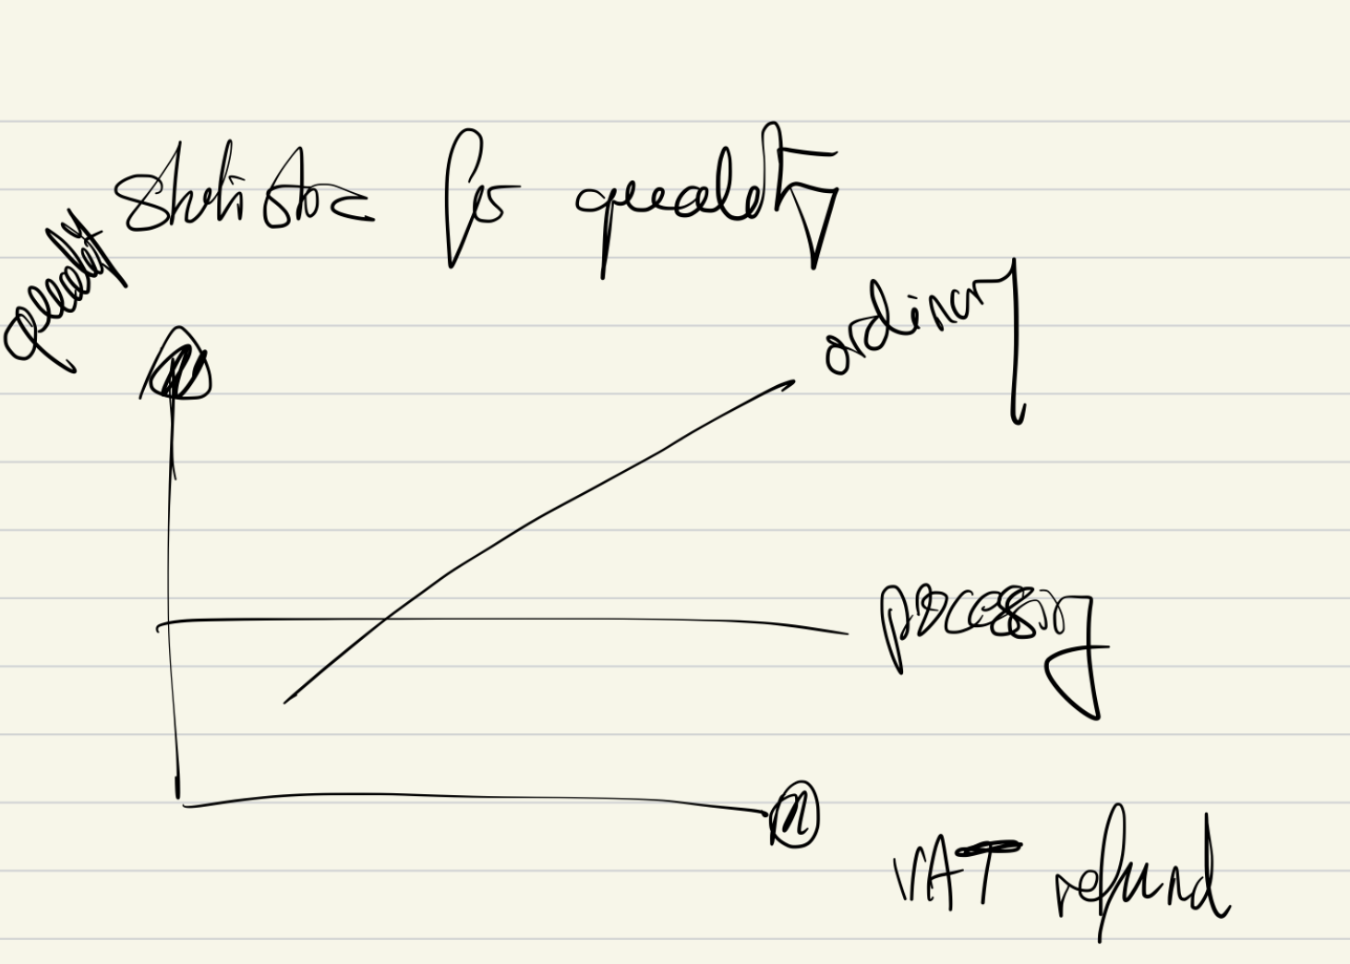

In [ ]:
query = """
SELECT * , vat_reb_m / vat_m as refund
FROM "chinese_trade"."hs6_china_vat_rebate"
WHERE hs6 in ('{}')
ORDER BY hs6, year
""".format("', '".join(list(df_unique.assign(cn_2 = lambda x: x.groupby([
          "hs6", 
          "geocode4_corr", 
          "country_en"])['regime'].transform("size")
                ).loc[lambda x: x['cn_2'].isin([16])]['hs6'].unique().astype(str)))
          )
df = s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='fig1',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = {'hs6':'string'}
)

In [ ]:
(
    df
    .loc[lambda x: x['year'] <= 2010]
    .assign(
         #hs6=lambda x: np.where(
         #   x["hs6"].astype("str").str.len() == 5,
         #   "00" + x["hs6"].astype("str"),
         #   x["hs6"].astype("str"),
        #),
        hs6 = lambda x: x['hs6'].astype(str),
        pct_change = lambda x: x.groupby('hs6')['refund'].transform("pct_change"),
        min_ = lambda x: x.groupby('hs6')['refund'].transform("min"),
        max_= lambda x: x.groupby('hs6')['refund'].transform("max"),
        
    )
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .loc[lambda x: x['min_'] != x['max_']]
    #.loc[lambda x: x['hs6'].isin(['110813'])]
    .assign(
    size_= lambda x: x.groupby('hs6')['refund'].transform("size")
    )
    .loc[lambda x: x['size_'] > 1]
    .assign(
        min_ = lambda x: x.groupby('hs6')['year'].transform("min"),
        max_= lambda x: x.groupby('hs6')['year'].transform("max"),
    )
    .loc[lambda x:
         x['min_'].isin([2003])
        &
         x['max_'].isin([2010])
        ]
    .set_index(['hs6', 'year'])
    .reindex(columns = ['refund'])
    .unstack(-1)
    #.loc[lambda x: x[('refund', 2003)] < x[('refund', 2010)]]
    .sort_values(by = [('refund', 2003)])
)

In [ ]:
id_ = 940190
query = """
SELECT year, regime, AVG(kandhelwal_quality) as kandhelwal_quality
FROM chinese_trade.china_vat_quality
WHERE hs6 in ('{}')
GROUP BY year, regime
ORDER BY year, regime
""".format(id_)
df_1 = s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='fig1',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = {'hs6':'string'}
)
df_temp = (
    df
    .loc[lambda x: x['hs6'].isin([id_])]
    .set_index(['year'])
    .reindex(columns = ['refund'])
    .merge(
    (
    df_1
    .set_index(['year', 'regime'])
    .unstack(-1)
    
    .collapse_levels(sep='_')
),left_index=True, right_index=True
    )
)
fig, ax1 = plt.subplots(figsize=(15,10))

ax2 = ax1.twinx()
ax1.plot(df_temp.index, df_temp['kandhelwal_quality_ELIGIBLE'], 'g-') ### eligible
ax1.plot(df_temp.index, df_temp['kandhelwal_quality_NOT_ELIGIBLE'], 'r-')
ax2.plot(df_temp.index, df_temp['refund'], 'b-')

ax1.set_xlabel('Year')
ax1.set_ylabel('Product Quality', color='g')
ax2.set_ylabel('VAT Refund', color='b')

plt.show()

In [ ]:
sns.lmplot(x="refund", 
           y="kandhelwal_quality", 
           hue="regime",
           data=df_unique.assign(refund = lambda x: x['lag_vat_reb_m']/x['lag_vat_m']), 
           height=10)
plt.xlabel("VAT refund")
plt.ylabel("Product quality")
#plt.savefig("How_To_Add_Regression_Line_per_group_Seaborn.png",
#                    format='png',dpi=150)

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp
import sys
path = os.getcwd()
parent_path = str(Path(path).parent.parent)
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc
import create_report

In [ ]:
name_json = 'parameters_ETL_VAT_rebate_quality_china.json'
path_json = os.path.join(str(Path(path).parent.parent), 'utils',name_json)

In [ ]:
create_report.create_report(extension = "html", keep_code = False, notebookname = "00_final_publishable_tables_figures.ipynb")

In [ ]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          #os.path.join(str(Path(path).parent), "00_download_data_from"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)